#Neural Style Transfer (NST) using the pre-trained VGG model

The objective here is to demonstrate how, by using 2 images -  a content image (the base photo) and a style image (the reference for the desired style or visual appearance) - I can transfer the style from the style image to the content image, while preserving the original content of the base image:

In [2]:
!pip install torchvision

In [2]:
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert('RGB') # Convert the image to RGB

    # If the image is larger than the maximum size, resize it
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    # Preprocess the image from (h, w, 3) array to a (3, h, w) tensor & normalizes pixels
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0) #adds an extra batch dim - PyTorch expects images passed thru models as batches
    return image

In [7]:
# Load images from Google Drive path
content_image_path = '/content/fitter.png'
style_image_path = '/content/selfie.png'

# Load and preprocess the images
content_image = load_image(content_image_path)
style_image = load_image(style_image_path)


In [8]:
# Function to display images
def imshow(tensor, title=None):
    tensor = tensor.cpu().clone()  # Clone tensor to avoid changing the original
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = transforms.ToPILImage()(tensor)  # Convert to PIL image
    plt.imshow(tensor)
    if title:
        plt.title(title)
    plt.show()

In [9]:
# Load and preprocess the images
content_image = load_image(content_image_path)
style_image = load_image(style_image_path)

In [10]:
# Define the VGG19 model (pre-trained) for style transfer
vgg = models.vgg19(pretrained=True).features.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.1MB/s]


In [11]:
# Check if CUDA is available (use GPU for faster computation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step 0, Loss 0.000987237668596208
Step 50, Loss 3.1495165824890137
Step 100, Loss 1.0521353483200073
Step 150, Loss 1.3079969882965088
Step 200, Loss 50.661895751953125
Step 250, Loss 20.297012329101562


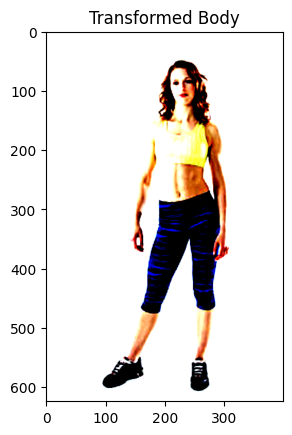

In [13]:
# Check if CUDA is available (use GPU for faster computation)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_image = content_image.to(device)
style_image = style_image.to(device)
vgg = vgg.to(device)

# Extract features from specific layers
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # content layer
        '28': 'conv5_1'
    }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram matrix function (used for style loss)
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

# Compute the loss function (content + style)
def compute_loss(content_features, style_features, target_features):
    content_weight = 1e4
    style_weight = 1e2

    # Content loss (difference between content image and target)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss (difference between style image and target)
    style_loss = 0
    for layer in style_features:
        gram_target = gram_matrix(target_features[layer])
        gram_style = gram_matrix(style_features[layer])
        style_loss += torch.mean((gram_target - gram_style)**2)

    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Create a copy of the content image to optimize
target_image = content_image.clone().requires_grad_(True).to(device)

# Define optimizer
optimizer = optim.Adam([target_image], lr=0.003)

# Run the style transfer for a set number of iterations
num_steps = 300
for step in range(num_steps):
    optimizer.zero_grad()

    # Extract features
    target_features = get_features(target_image, vgg)
    content_features = get_features(content_image, vgg)
    style_features = get_features(style_image, vgg)

    # Compute the loss
    loss = compute_loss(content_features, style_features, target_features)
    loss.backward()

    optimizer.step()

    # Print progress every 50 steps
    if step % 50 == 0:
        print(f"Step {step}, Loss {loss.item()}")

# Convert the final image to a displayable format and show it
final_img = target_image.squeeze().cpu().detach()
final_img = final_img.clamp(0, 1)
imshow(final_img, title="Transformed Body")


# Tips on improving model

Some optimizations to try to speed up the process, especially leveraging Colab's GPU (if available) and making a few adjustments to the code itself.


### **Optimize the VGG model**

The VGG model is quite deep and computing feature maps from all layers for every iteration is slow. You can limit the layers you use for style transfer to improve performance. For example, you might only use the first few convolution layers for style loss and the later layers for content loss.

### **Adjust the number of iterations**

The number of iterations you're using (`num_steps = 300`) might be high for a quick test. You can reduce this to speed up the process, especially when experimenting. Once you’re happy with the results, you can run more iterations for refinement:

```python
num_steps = 100  # Reduce for faster experimentation
```

### **Use a lower learning rate**

A high learning rate can cause the model to converge slowly or in an unstable manner, which might result in longer training times. You can try lowering the learning rate and see if that speeds up the process without sacrificing much performance.


###  **Use TorchScript (optional)**

For better performance for production use, TorchScript can optimize and speed up your PyTorch model. But for now, the above steps should improve your code’s performance without needing to go into advanced optimizations like TorchScript.
